# LAVD and Lagrangian eddies

## Just a little info about the code

Created on: 13.09.2024

Last edited: 17.09.2024

Created by: Stella Bērziņa (stella.berzina@usys.eth.ch)

This notebook aims to document how to calculate LAVD fields from taking input velocity fields from ICON EERIE runs. After LAVD fields are calculated, RCLVs are identified in the fields. Tracking of the RCLVs is also shown. 

This notebook is heavily based on Lexi Jones-Kellett (MIT) example_usage.ipynb which is published along with her code. The functions in this notebook are a combination of **RCLVatlas** by Lexi Jones-Kellett (MIT) (https://github.com/lexi-jones/RCLVatlas) and **xlcs** by Philippe Miron (https://github.com/philippemiron/xlcs). Both initially use **Parcels**  (https://github.com/OceanParcels/Parcels) to create the Lagrangian trajectories and the **Floater** (https://github.com/ocean-transport/floater) to identify the RCLVs. 

My job here is to take the bits that I like from other people's work and alter it to work with the model output data that I have (which I also did not create). So thanks to about a million people for working for years so that I could do this.

## Python Environment
**DOCUMENT LATER**


I would follow the installation steps noted down in RCLVatlas (https://github.com/lexi-jones/RCLVatlas) to have an environment where Parcels runs. 
Also, to make the intake library run, there are a couple of packages

## LAVD calculation

**Input data:**  ICON, 0.25 regridded velocity fields from the intake catalog.

**Output data:** lagrangian trajectories folder, LAVD field.

The run_parcels_CMEMC.py file is changed from the original by feeding in EERIE intake catalogue and uses functions from xlcs package

### How to run the LAVD and lagrangian trajectory calculation:

1. Activate parcels environment in your terminal by running
   `conda activate parcels_environment`
2. Go into the path in your directory where the RCLVatlas package is stored
   `cd ./RCLVatlas/`
1. Setup the config.py file with the following params (default):
- grid_bounds = {
               'lon_bound_west':350.0,
               'lon_bound_east':10.0,
               'lat_bound_south':-80.0,
               'lat_bound_north':80.0,
               'lag_grid_res':0.03125
               }

# there currently is an error with boundaries and lagrangian particles, that is why we remove 10 deg from either end
  

- sim_params = {
              'runtime':10, 
              'runtime_unit':'days',
              'timestep':20, 
              'output_freq':6,
              'backwards':'y'
              } 

- RCLV_params = {
               'min_dist':24,
               'min_area':104,
               'init_contour_step_frac':0.1,
               'convex_def_tol':0.001
               }

2. Run the following lines in the command line to simulate the Lagrangian trajectories and calculate the Lagrangian averaged vorticity deviation (LAVD)
- `python run_parcels_CMEMS.py 20020410`
- `python run_parcels_CMEMS.py 20020420`
- `python run_parcels_CMEMS.py 20020430`

At this point, you will have 3 10-day backward-in-time Lagrangian trajectories calculated for a 5x5 degree box near Hawaii. You will also have the LAVD calculated for each of these runs, which will be used to identify RCLVs. 

# Plotting LAVD

The following code is heavily based on RCLVatlas example_usage notebook

In [1]:
import os,sys
import trajan
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from config import *

sys.path.append('./RCLVatlas')
from subfunctions_for_RCLV_atlas import read_RCLV_CSV_untracked,read_RCLV_CSV_tracked,save_RCLV_CSV
from mainfunctions_for_RCLV_atlas import *



/home/b/b382618/.conda/envs/parcels2/lib/python3.11/site-packages/pyproj/__init__.py:89: UserWarning: pyproj unable to set database path.
  _pyproj_global_context_initialize()


## LAVD plot

In [2]:
dates = [filename[0:8] for filename in os.listdir(LAVD_dir)]
date_list = np.sort(np.unique(dates)).tolist()[::-1] #Reverse the order because we will iterate from the latest date to the earliest
date_list

['20101227',
 '20101219',
 '20101211',
 '20101203',
 '20101125',
 '20101117',
 '20101109',
 '20101101',
 '20101024',
 '20101016',
 '20101008',
 '20100930',
 '20100922',
 '20100914',
 '20100906',
 '20100829',
 '20100821',
 '20100813',
 '20100805',
 '20100728',
 '20100720',
 '20100712',
 '20100704',
 '20100626',
 '20100618',
 '20100610',
 '20100602',
 '20100525',
 '20100517',
 '20100509',
 '20100501']

In [13]:
### original keeppp

LAVD_output_file_path = LAVD_dir + date_list[0] + '_LAVD_' + filename_str + '.npy'
LAVD = np.load(LAVD_output_file_path)
LAVD = np.ma.masked_where(np.isnan(LAVD),LAVD) #Land mask required for the peak_local_max function to work
LAVD_reshape = np.transpose(np.reshape(LAVD,(len(traj_lon_array),len(traj_lat_array))))

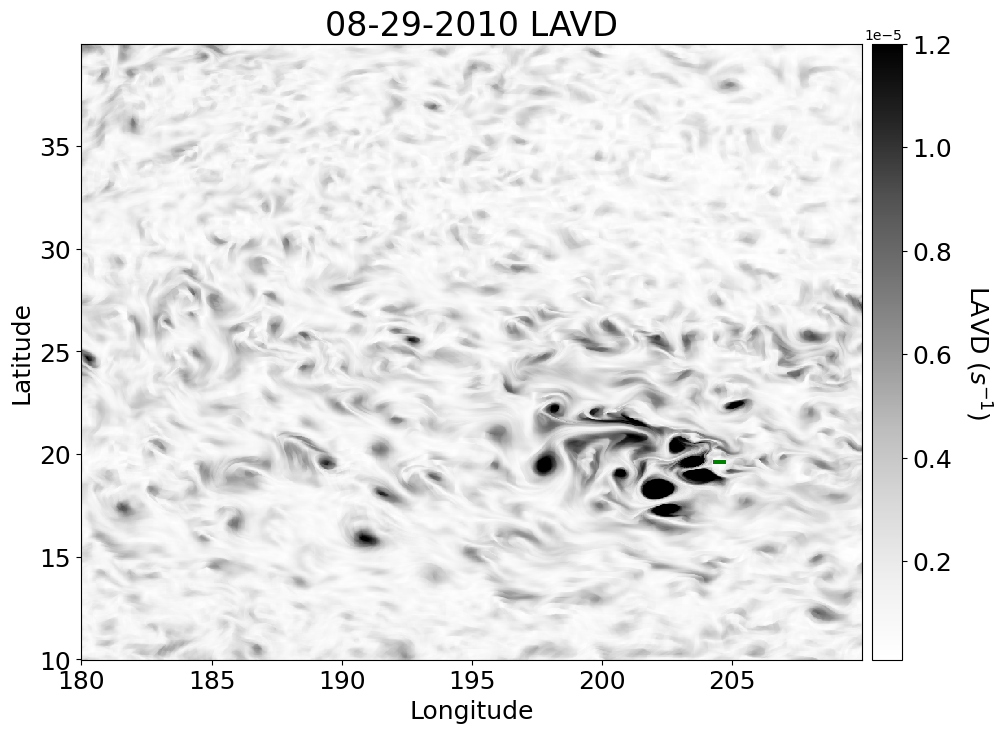

In [14]:
fontsize = 18

fig,ax = plt.subplots(1,1,figsize=(12,8))
ax.set_facecolor("g")
plot = ax.pcolormesh(traj_lon_array,traj_lat_array,LAVD_reshape,shading='nearest',cmap='Greys',vmin=10**(-7), vmax=1.2*(10**(-5)));

cbar = plt.colorbar(plot, pad = 0.01)
cbar.ax.tick_params(labelsize=18)
cbar.ax.get_yaxis().labelpad = 30
cbar.ax.set_ylabel('LAVD $(s^{-1})$', rotation=270, fontsize=fontsize)
    
ax.set_xlabel('Longitude',fontsize=fontsize)
ax.set_ylabel('Latitude',fontsize=fontsize)
ax.tick_params(axis='both', which='major', labelsize=fontsize)
ax.set_title('%s-%s-%s LAVD'%(date_list[0][4:6],date_list[0][6:8],date_list[0][0:4]),fontsize=24)

plt.show()

## Identify RCLVs

**Note to myself**-  IN SUBFUNCTIONS.PY I ADDED INLINES 56-59 THE -1 AFTER THE TIME INDEX BC OTHERWISE IT WAS NOT WORKING ~!!! KEEP THAT IN MIND 


In [1]:
# #######original
# RCLV_data = np.array(set_up_RCLV_atlas(date_list),dtype=object) 
# print('Length of RCLV_data: %s'%(len(RCLV_data)))
# save_RCLV_CSV(RCLV_data,'%sRCLV_%s_%s_untracked.csv'%(RCLV_dir,date_list[-1],date_list[0])) #save RCLV as CSV

In [3]:
RCLV_data = np.array(set_up_RCLV_atlas(date_list),dtype=object) 
print('Length of RCLV_data: %s'%(len(RCLV_data)))
save_RCLV_CSV(RCLV_data,'%schangedRCLV_%s_%s_untracked.csv'%(RCLV_dir,date_list[-1],date_list[0])) #save RCLV as CSV

Identifying RCLVs...
20101203
['/work/bk1377/b382618/RCLVs/32day/lang_traj/20101203_32days_runtime_20min_timestep_particle_start_lat_10.0_40.0_lon_180.0_210.0_spatial_step_0.03125_6hr_output_freq.zarr']


/home/b/b382618/.conda/envs/parcels2/lib/python3.11/site-packages/xarray/backends/plugins.py:159: RuntimeWarning: 'netcdf4' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)
/home/b/b382618/.conda/envs/parcels2/lib/python3.11/site-packages/xarray/backends/plugins.py:159: RuntimeWarning: 'scipy' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)


20101101
['/work/bk1377/b382618/RCLVs/32day/lang_traj/20101101_32days_runtime_20min_timestep_particle_start_lat_10.0_40.0_lon_180.0_210.0_spatial_step_0.03125_6hr_output_freq.zarr']


/home/b/b382618/.conda/envs/parcels2/lib/python3.11/site-packages/xarray/backends/plugins.py:159: RuntimeWarning: 'netcdf4' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)
/home/b/b382618/.conda/envs/parcels2/lib/python3.11/site-packages/xarray/backends/plugins.py:159: RuntimeWarning: 'scipy' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)


variance_t0:  174.9232676332463 variance_tx: 401.47632458978507
CI:  -1.2951567851541759
variance_t0:  246.90898398224797 variance_tx: 569.8409107103802
CI:  -1.3078986496147507
variance_t0:  206.65171011806615 variance_tx: 290.22336724912805
CI:  -0.40440825330366237
variance_t0:  503.3619239927318 variance_tx: 529.2513360420064
CI:  -0.0514329964489893
20100930
['/work/bk1377/b382618/RCLVs/32day/lang_traj/20100930_32days_runtime_20min_timestep_particle_start_lat_10.0_40.0_lon_180.0_210.0_spatial_step_0.03125_6hr_output_freq.zarr']


/home/b/b382618/.conda/envs/parcels2/lib/python3.11/site-packages/xarray/backends/plugins.py:159: RuntimeWarning: 'netcdf4' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)
/home/b/b382618/.conda/envs/parcels2/lib/python3.11/site-packages/xarray/backends/plugins.py:159: RuntimeWarning: 'scipy' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)


variance_t0:  494.0570152544766 variance_tx: 488.05944366094815
CI:  0.012139432106715956
variance_t0:  673.4992415696198 variance_tx: 1500.6745443504697
CI:  -1.2281755519918347
variance_t0:  1039.8037142065973 variance_tx: 844.5389155919245
CI:  0.18779005686055464
variance_t0:  319.3501228292957 variance_tx: 262.94177048620304
CI:  0.17663482275610387
20100829
['/work/bk1377/b382618/RCLVs/32day/lang_traj/20100829_32days_runtime_20min_timestep_particle_start_lat_10.0_40.0_lon_180.0_210.0_spatial_step_0.03125_6hr_output_freq.zarr']


/home/b/b382618/.conda/envs/parcels2/lib/python3.11/site-packages/xarray/backends/plugins.py:159: RuntimeWarning: 'netcdf4' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)
/home/b/b382618/.conda/envs/parcels2/lib/python3.11/site-packages/xarray/backends/plugins.py:159: RuntimeWarning: 'scipy' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)


variance_t0:  239.9606287515058 variance_tx: 318.2508200213597
CI:  -0.32626265265760857
variance_t0:  190.7989856128421 variance_tx: 259.5783537844437
CI:  -0.3604807853180341
20100728
['/work/bk1377/b382618/RCLVs/32day/lang_traj/20100728_32days_runtime_20min_timestep_particle_start_lat_10.0_40.0_lon_180.0_210.0_spatial_step_0.03125_6hr_output_freq.zarr']


/home/b/b382618/.conda/envs/parcels2/lib/python3.11/site-packages/xarray/backends/plugins.py:159: RuntimeWarning: 'netcdf4' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)
/home/b/b382618/.conda/envs/parcels2/lib/python3.11/site-packages/xarray/backends/plugins.py:159: RuntimeWarning: 'scipy' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)


variance_t0:  405.7468267371363 variance_tx: 482.8722924133158
CI:  -0.19008273286175406
variance_t0:  320.124194416621 variance_tx: 1431.320200133523
CI:  -3.4711403420847105
20100626
['/work/bk1377/b382618/RCLVs/32day/lang_traj/20100626_32days_runtime_20min_timestep_particle_start_lat_10.0_40.0_lon_180.0_210.0_spatial_step_0.03125_6hr_output_freq.zarr']


/home/b/b382618/.conda/envs/parcels2/lib/python3.11/site-packages/xarray/backends/plugins.py:159: RuntimeWarning: 'netcdf4' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)
/home/b/b382618/.conda/envs/parcels2/lib/python3.11/site-packages/xarray/backends/plugins.py:159: RuntimeWarning: 'scipy' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)


variance_t0:  373.8915627303527 variance_tx: 388.61466470289844
CI:  -0.03937800004105447
variance_t0:  295.3839774917332 variance_tx: 293.56516681640437
CI:  0.006157445270976995
20100525
['/work/bk1377/b382618/RCLVs/32day/lang_traj/20100525_32days_runtime_20min_timestep_particle_start_lat_10.0_40.0_lon_180.0_210.0_spatial_step_0.03125_6hr_output_freq.zarr']


/home/b/b382618/.conda/envs/parcels2/lib/python3.11/site-packages/xarray/backends/plugins.py:159: RuntimeWarning: 'netcdf4' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)
/home/b/b382618/.conda/envs/parcels2/lib/python3.11/site-packages/xarray/backends/plugins.py:159: RuntimeWarning: 'scipy' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)


variance_t0:  244.23964555698595 variance_tx: 222.70881614553534
CI:  0.08815452283493853
variance_t0:  443.96038781249547 variance_tx: 743.3143915653174
CI:  -0.674280886247114
variance_t0:  346.0174778822931 variance_tx: 624.384215086949
CI:  -0.8044875042391633
Length of RCLV_data: 11


In [7]:
save_RCLV_CSV(RCLV_data,'%schangedRCLV_%s_%s_untracked.csv'%(RCLV_dir,date_list[-1],date_list[0])) #save RCLV as CSV

## Tracking eddies 

Currently there is an issue where if the last (???) day does not have any RCLVs then it does not finish the tracking.

In [6]:
## I need to track my backard eddie

In [4]:
RCLV_data = np.array(read_RCLV_CSV_untracked('%schangedRCLV_%s_%s_untracked.csv'%(RCLV_dir,date_list[-1],date_list[0]),1),dtype=object)
RCLV_data = track_and_ID_RCLVs(RCLV_data,date_list)
save_RCLV_CSV(RCLV_data,'%schangedRCLV_%s_%s_tracked_with_ID.csv'%(RCLV_dir,date_list[-1],date_list[0])) # Save the tracked data as a CSV

Tracking eddies through time & IDing...
Number of identical contours to remove: 0
20101203
20101101


/home/b/b382618/.conda/envs/parcels2/lib/python3.11/site-packages/xarray/backends/plugins.py:159: RuntimeWarning: 'netcdf4' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)
/home/b/b382618/.conda/envs/parcels2/lib/python3.11/site-packages/xarray/backends/plugins.py:159: RuntimeWarning: 'scipy' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)
/home/b/b382618/.conda/envs/parcels2/lib/python3.11/site-packages/xarray/backends/plugins.py:159: RuntimeWarning: 'netcdf4' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)
/home/b/b382618/.conda/envs/parcels2/lib/python3.11/site-packages/xarray/backends/plugins.py:159: RuntimeWarning: 'scipy' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)


20100930


/home/b/b382618/.conda/envs/parcels2/lib/python3.11/site-packages/xarray/backends/plugins.py:159: RuntimeWarning: 'netcdf4' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)
/home/b/b382618/.conda/envs/parcels2/lib/python3.11/site-packages/xarray/backends/plugins.py:159: RuntimeWarning: 'scipy' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)


KeyboardInterrupt: 

In [5]:
# #####original

# RCLV_data = np.array(read_RCLV_CSV_untracked('%sRCLV_%s_%s_untracked.csv'%(RCLV_dir,date_list[-1],date_list[0]),1),dtype=object)
# RCLV_data = track_and_ID_RCLVs(RCLV_data,date_list)
# save_RCLV_CSV(RCLV_data,'%sRCLV_%s_%s_tracked_with_ID.csv'%(RCLV_dir,date_list[-1],date_list[0])) # Save the tracked data as a CSV

Somewhat of a QC step. I currently don't do the interpolation because it gave me errors and I can live without it

TO MAKE THE interpolate_skipped_contours WORK I AGAIN NEEDED TO -1 IN 358/9 LINE!! WHY IS THATTT???

In [ ]:
# #### original
# log_file = open('%sRCLV_%s_%s_log_file.txt'%(RCLV_dir,date_list[-1],date_list[0]),'a')
# RCLV_data = read_RCLV_CSV_tracked('%sRCLV_%s_%s_tracked_with_ID.csv'%(RCLV_dir,date_list[-1],date_list[0]))    
# # RCLV_data = interpolate_skipped_contours(RCLV_data,log_file,date_list)
# # save_RCLV_CSV(RCLV_data,'%sRCLV_%s_%s_skips_interpolated.csv'%(RCLV_dir,date_list[-1],date_list[0]))


In [5]:
log_file = open('%schangedRCLV_%s_%s_log_file.txt'%(RCLV_dir,date_list[-1],date_list[0]),'a')
RCLV_data = read_RCLV_CSV_tracked('%schangedRCLV_%s_%s_tracked_with_ID.csv'%(RCLV_dir,date_list[-1],date_list[0]))    
# RCLV_data = interpolate_skipped_contours(RCLV_data,log_file,date_list)
# save_RCLV_CSV(RCLV_data,'%sRCLV_%s_%s_skips_interpolated.csv'%(RCLV_dir,date_list[-1],date_list[0]))

In [ ]:
# #####original

# # RCLV_data = read_RCLV_CSV_tracked('%sRCLV_%s_%s_skips_interpolated.csv'%(RCLV_dir,date_list[-1],date_list[0]))
# RCLV_data = read_RCLV_CSV_tracked('%sRCLV_%s_%s_tracked_with_ID.csv'%(RCLV_dir,date_list[-1],date_list[0]))

# RCLV_data = age_RCLVs(RCLV_data)
# save_RCLV_CSV(RCLV_data,'%sRCLV_%s_%s_atlas.csv'%(RCLV_dir,date_list[-1],date_list[0])) # Save the final dataset
# RCLV_data = np.array(RCLV_data,dtype=object)

In [6]:
# # RCLV_data = read_RCLV_CSV_tracked('%sRCLV_%s_%s_skips_interpolated.csv'%(RCLV_dir,date_list[-1],date_list[0]))
# RCLV_data = read_RCLV_CSV_tracked('/work/bk1377/b382618/RCLVs/8day/RCLV_dir_changed/changedRCLV_20100501_20101227_tracked_with_ID.csv')
# RCLV_data = age_RCLVs(RCLV_data)
# save_RCLV_CSV(RCLV_data,'%schangedRCLV_%s_%s_atlas.csv'%(RCLV_dir,date_list[-1],date_list[0])) # Save the final dataset
# RCLV_data = np.array(RCLV_data,dtype=object)

In [6]:
# RCLV_data = read_RCLV_CSV_tracked('%sRCLV_%s_%s_skips_interpolated.csv'%(RCLV_dir,date_list[-1],date_list[0]))
RCLV_data = read_RCLV_CSV_tracked('%schangedRCLV_%s_%s_tracked_with_ID.csv'%(RCLV_dir,date_list[-1],date_list[0]))

RCLV_data = age_RCLVs(RCLV_data)
save_RCLV_CSV(RCLV_data,'%schangedRCLV_%s_%s_atlas.csv'%(RCLV_dir,date_list[-1],date_list[0])) # Save the final dataset
RCLV_data = np.array(RCLV_data,dtype=object)

Giving RCLVs an age & saving the final atlas...


## Eddies + LAVD fiels 

IndexError: index 3 is out of bounds for axis 0 with size 3

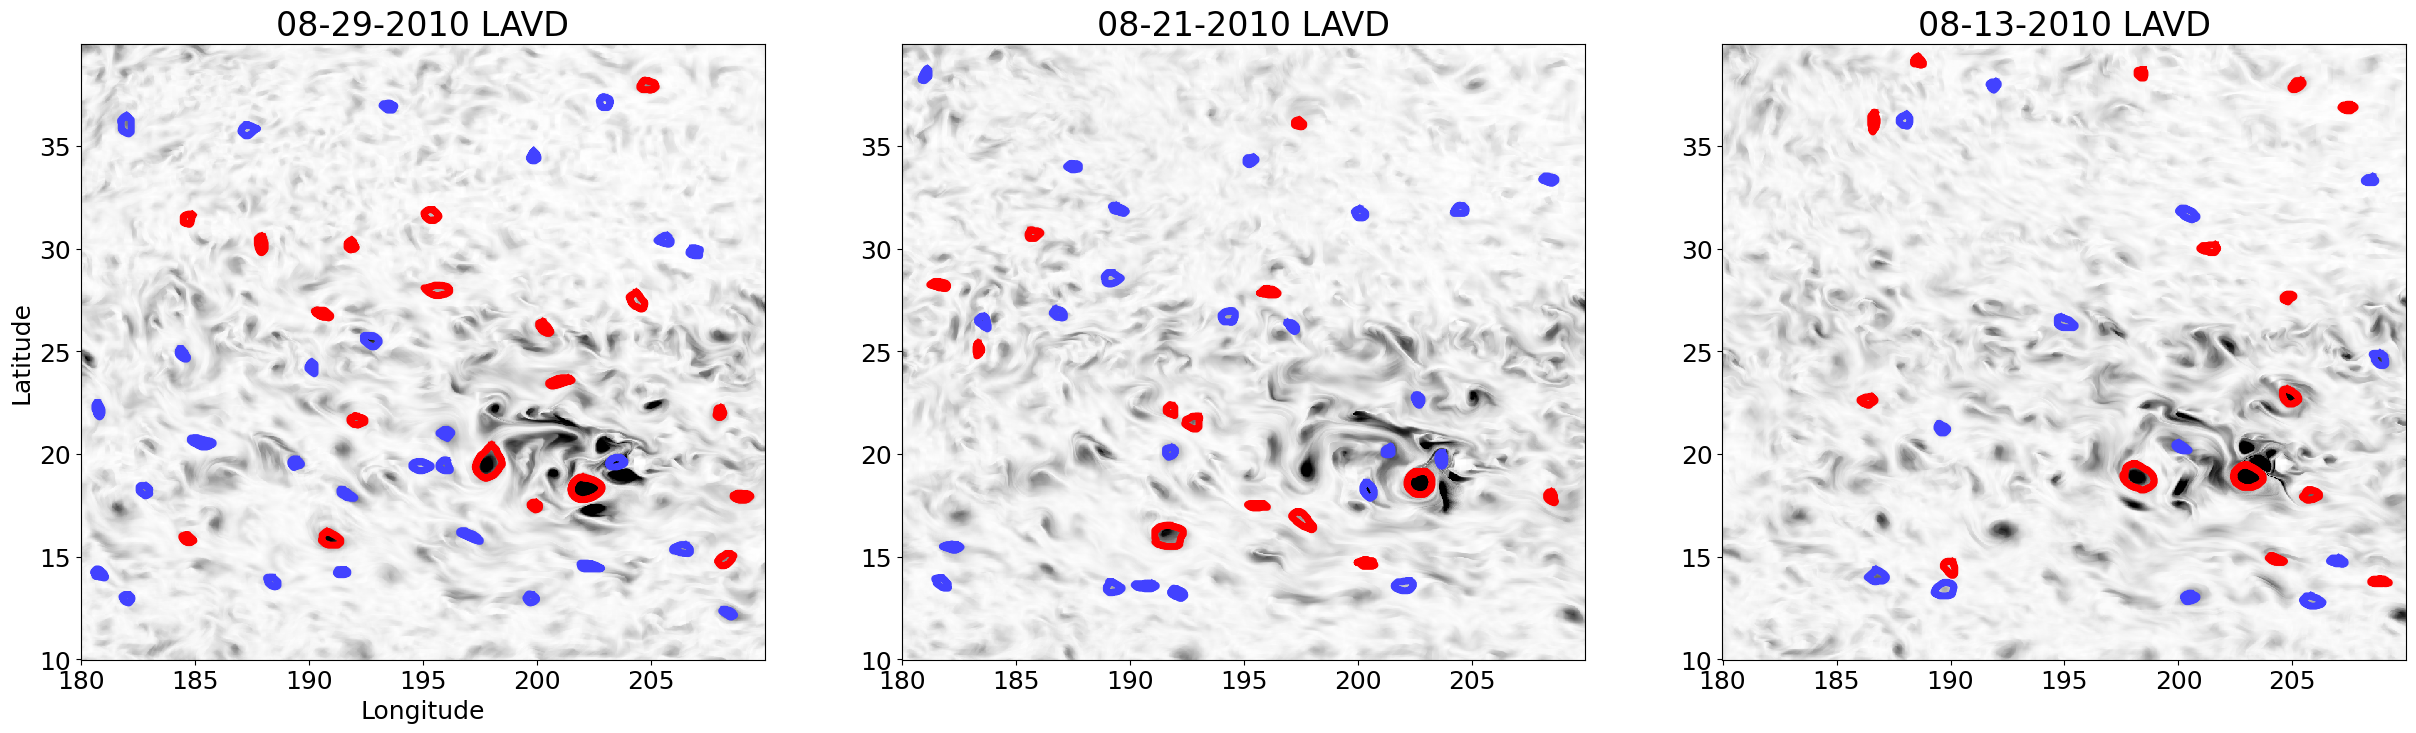

In [19]:
fontsize = 18
fig,ax = plt.subplots(1,3,figsize=(30,8))

ax[0].set_xlabel('Longitude',fontsize=fontsize)
ax[0].set_ylabel('Latitude',fontsize=fontsize)

c = 0
for date in date_list:
    # Load the LAVD data
    LAVD_output_file_path = LAVD_dir + date + '_LAVD_' + filename_str + '.npy'
    LAVD = np.load(LAVD_output_file_path)
    LAVD = np.ma.masked_where(np.isnan(LAVD),LAVD) #Land mask required for the peak_local_max function to work
    LAVD_reshape = np.transpose(np.reshape(LAVD,(len(traj_lon_array),len(traj_lat_array))))
    
    # Plot the LAVD 
    plot = ax[c].pcolormesh(traj_lon_array,traj_lat_array,LAVD_reshape,shading='nearest',cmap='Greys',vmin=10**(-7), vmax=1.2*(10**(-5)));
    ax[c].tick_params(axis='both', which='major', labelsize=fontsize)
    ax[c].set_title('%s-%s-%s LAVD'%(date[4:6],date[6:8],date[0:4]),fontsize=24)

    # Plot the RCLVs for the given date
    RCLV_data_this_day = RCLV_data[np.where([r[0]==date for r in RCLV_data])[0]]
    RCLV_bnds = [r[9:] for r in RCLV_data_this_day] # boundary coordinates
    RCLV_orientations = [r[2] for r in RCLV_data_this_day] # eddy polarity
    
    for i in np.arange(0,len(RCLV_bnds)):
        x_bnds = [float(coord) for coord in RCLV_bnds[i][0::2]]
        y_bnds = [float(coord) for coord in RCLV_bnds[i][1::2]]

        if RCLV_orientations[i] == 'anti':
            color = '#FF0000'
        else:
            color = '#4242FF'
        ax[c].plot(x_bnds,y_bnds,linewidth=5,c=color)
    c += 1

plt.show()

color by RCLV age

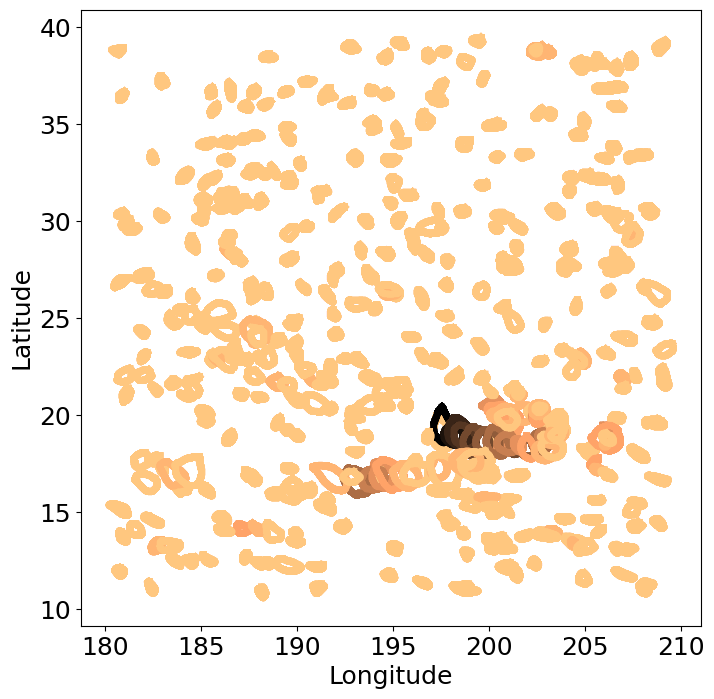

In [9]:
RCLV_bnds = [r[9:] for r in RCLV_data[1:]] # boundary coordinates
RCLV_ages = [r[3] for r in RCLV_data[1:]] # ages
norm = colors.Normalize(vmin=min(RCLV_ages), vmax=max(RCLV_ages))

fontsize = 18
fig,ax = plt.subplots(1,1,figsize=(8,8))

for date in date_list:
    for i in np.arange(0,len(RCLV_bnds)):
        x_bnds = [float(coord) for coord in RCLV_bnds[i][0::2]]
        y_bnds = [float(coord) for coord in RCLV_bnds[i][1::2]]
        ax.plot(x_bnds,y_bnds,linewidth=5,c=plt.cm.copper_r(norm(RCLV_ages[i])))
            
ax.set_xlabel('Longitude',fontsize=fontsize)
ax.set_ylabel('Latitude',fontsize=fontsize)
ax.tick_params(axis='both', which='major', labelsize=fontsize)

plt.show()